# Setup
## Import and git root

In [264]:

import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git


from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl


In [203]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway reference variables

In [204]:
bd.projects.set_current('SEE_LAB') 

# Exploration
## Brightway (pre-existing)

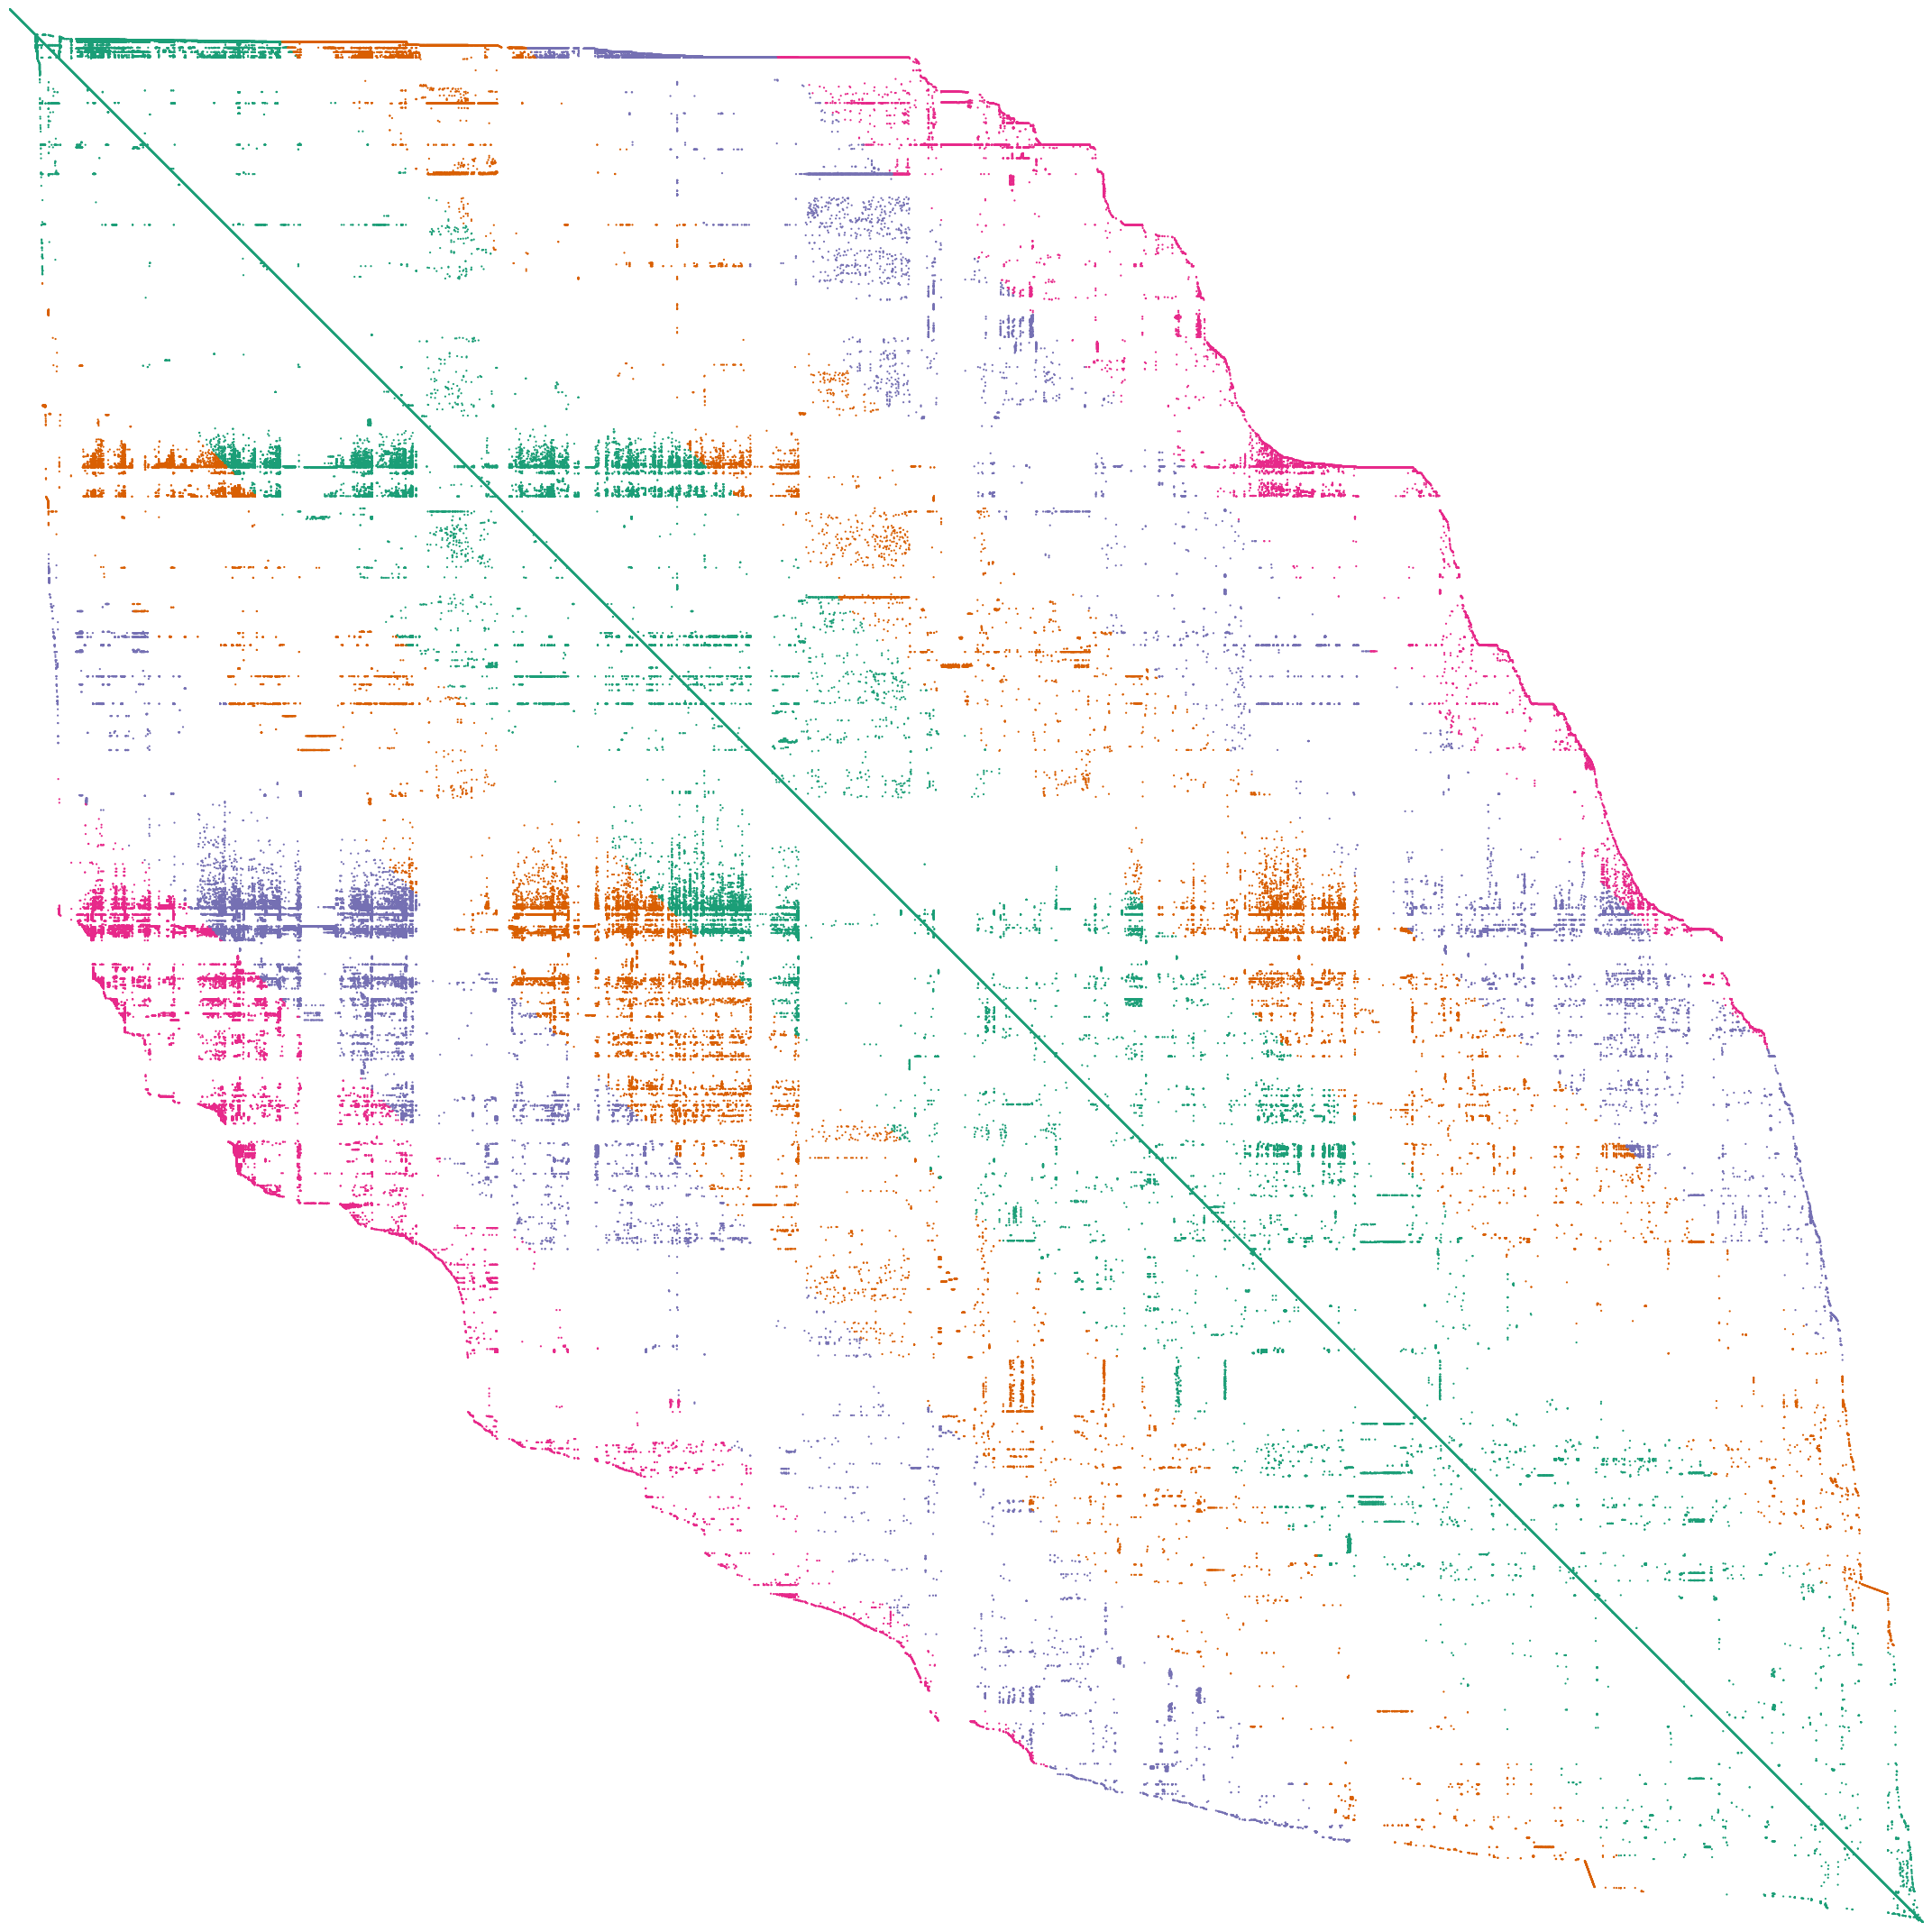

In [ ]:
eidb = bd.Database("ecoinvent-3.9.1-cutoff")
eidb.graph_technosphere()


In [206]:
random_act = eidb.random()
random_act.as_dict()

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis dataset represents the supply of 1 kg of \'sunflower seed, Swiss integrated production\' from activities that produce it within the geography of CH. Transportation is included in this market, based on Valsasina, L. (2016), "Default transport data per commodity group for Switzerland, ecoinvent database version 3.3, ecoinvent Centre, Zürich, Switzerland", available on the ecoinvent\'s website http://www.ecoinvent.org/. More details can be found in the exchange comments of the transportation. \nIncluded activities start:  This activity starts at the gate of the activiti

In [207]:
for exc in random_act.exchanges():
    print(exc)

Exchange: 1.0 kilogram 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>
Exchange: 1.0 kilogram 'sunflower production, Swiss integrated production, intensive' (kilogram, CH, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>
Exchange: 0.00882 ton kilometer 'market for transport, freight train' (ton kilometer, CH, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>
Exchange: 0.0583215915997692 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'market for sunflower seed, Swiss integrated production' (kilogram, CH, None)>


In [ ]:
[exc for exc in random_act.exchanges()][0].as_dict()


TypeError: 'Exchanges' object is not subscriptable

## Original (trivial)
### Explore Activity Country Tags (all)
First we'll look at all the technosphere processes

In [209]:
## Create a dictionary of all the country codes counts (from the technosphere activities) and convert to a dataframe
global_dict = defaultdict(int)
for act in eidb:
    cc_code = act['location']
    global_dict[cc_code] += 1

country_frame  = pd.DataFrame(list(global_dict.items()), columns=['Country', 'Count'])
country_frame

,Country,Count
0,CH,2044
1,RoW,4210
2,CN-CQ,13
3,NZ,19
4,SA,22
...,...,...
304,IN-DD,1
305,RER w/o DE+NL+RU,1
306,Europe without Switzerland and Austria,1
307,WEU,2


We want to look at these as a map; this requires:
* shapesfiles for each country region (eg a global shapefile with provinces included)
* a dictionary or map to get from each country code to each shapefile 

Luckily, the database overview has a geographies sheet. We merge this now. 

In [210]:
geographies = pd.read_excel(f"{root}/Data/Database-Overview-for-ecoinvent-v3.10_29.04.24.xlsx", sheet_name="Geographies")
country_frame = pd.merge(
    left=country_frame,
    right=geographies,
    how='inner',
    left_on='Country',
    right_on='Shortname'
)
country_frame.drop(columns='Country', inplace=True)
country_frame.sort_values(by='Count', ascending=False).head(10)

,Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies
1,4210,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN
6,4025,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...
0,2044,131278d6-7d7e-11de-9ae2-0019e336be3a,Switzerland,CH,46.861000,7.908000,Country,NaN
13,1700,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
7,521,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
29,419,868a66d1-7428-4ba2-9125-253b07afc119,"Canada, Québec",CA-QC,53.390446,-71.755869,Province or State,NaN
24,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...
41,295,12b21766-7d7e-11de-9ae2-0019e336be3a,South Africa,ZA,-30.558000,23.121000,Country,NaN
84,259,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...
22,238,0e6a7860-7d7e-11de-9ae2-0019e336be3a,India,IN,21.000000,78.500000,Country,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...


Explore the distribution a little 

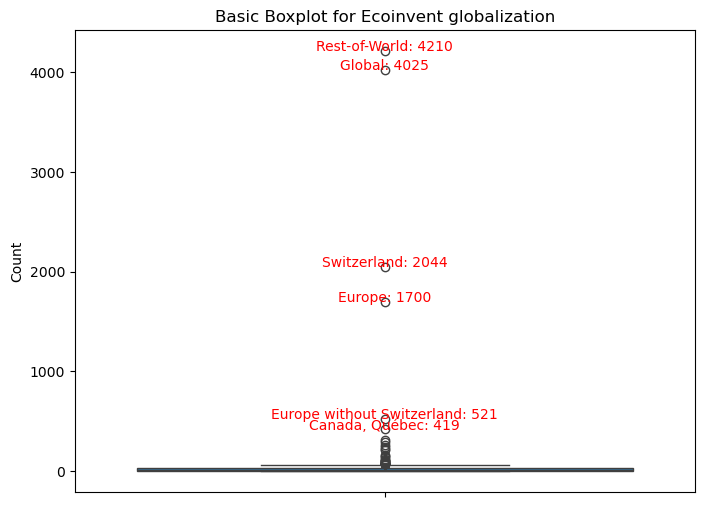

In [211]:
top5 = country_frame.sort_values(by='Count', ascending=False).head(6).copy()

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=country_frame, y='Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Count'], f"{outlier['Name']}: {outlier['Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

Note that:

* Global means global average production -- it **always** means that.
* Rest of World (RoW) means all the activites NOT explicitly locally defined. For example, if you have Switzerland and USA, than RoW means the global average minus those countries (from both numerator and denominator). Importantly, this means that RoW is **different** for every process (because they have different amounts of regional data)
* RoW values are not included if the regional values leave <.5% of the global production volume.

This means that in order to map RoW accurately we'll have to 'subtract' the process values we have (for that process)

Source: https://support.ecoinvent.org/geographies

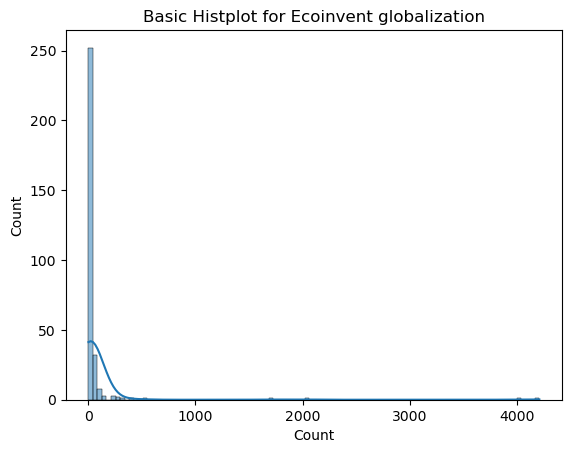

In [212]:
## Explore the distribution a little bit ... 
sns.histplot(data=country_frame['Count'], bins=100, kde=True)
plt.title("Basic Histplot for Ecoinvent globalization")
plt.show()

In [224]:
states = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_states_provinces_all/ne_10m_admin_1_states_provinces.shp")
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,None,AR,1,Entre Ríos,Entre-Rios,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,None,UY,1,Paysandú,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Admin-1 states provinces,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


In [284]:
countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
# for col in countries.columns:
#     print(col)
countries[countries['ISO_A2'] == 'US']

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
154,Admin-0 country,0,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."


In [214]:
country_frame.shape

(307, 8)

In [296]:
country_frame

,Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies
0,2044,131278d6-7d7e-11de-9ae2-0019e336be3a,Switzerland,CH,46.861000,7.908000,Country,NaN
1,4210,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN
2,13,8bc809e8-f246-46f7-bf1f-93e34e06befd,"China, Chongqing (重庆)",CN-CQ,NaN,NaN,Province or State,NaN
3,19,11258d1a-7d7e-11de-9ae2-0019e336be3a,New Zealand,NZ,-42.634000,172.235000,Country,NaN
4,22,129c6a88-7d7e-11de-9ae2-0019e336be3a,Saudi Arabia,SA,24.023000,44.585000,Country,NaN
...,...,...,...,...,...,...,...,...
302,1,653869da-6e3f-476e-9380-19d23040f2b9,"India, Daman and Diu",IN-DD,NaN,NaN,Province or State,NaN
303,1,5c322a16-89ab-48d4-b1a2-fec5759774a3,"Europe without Germany, the Netherlands, and R...",RER w/o DE+NL+RU,NaN,NaN,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
304,1,f4f87f1d-101c-4b43-b2de-f646734ae9fe,Europe without Switzerland and Austria,Europe without Switzerland and Austria,NaN,NaN,ecoinvent Custom Area,AD; AL; AX; BA; BALTSO; BE; BG; BY; Canary Isl...
305,2,de74489a-e3bf-4b3a-8463-b7b9eba8a8fb,Western Europe,WEU,48.532067,6.487221,UN Subregion,AT; BE; CH; DE; Europe without Austria; Europe...


In [ ]:
all_frame = county_frame.groupby()

In [329]:
matched_territories = pd.merge(
    left = country_frame,
    right = states,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'iso_3166_2'
)
matched_territories

countries_left = country_frame[~country_frame['Shortname'].isin(matched_territories['Shortname'])]
countries_left

matched_countries = pd.merge(
    left = countries_left,
    right = countries,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'ISO_A2'
)


grouped = matched_territories.groupby(matched_territories['Shortname'].str[:2])['Count'].sum().reset_index()
grouped
matched_added = pd.merge(
    matched_countries, grouped, on='Shortname', how='outer', suffixes=('_df1', '_df2'))
matched_added
matched_added['Count'] = matched_added['Count_df1'].fillna(0) + matched_added['Count_df2'].fillna(0)
matched_added[matched_added['Shortname'] == 'CN']

,Count_df1,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,featurecla,scalerank,...,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,Count_df2,Count
26,259,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.42,106.514,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,Admin-0 country,0,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((78.91769 33.38626, 78.91595 33...",463.0,722.0


In [314]:
country_frame[country_frame['Name'] == 'China']


,Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies
84,259,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.42,106.514,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...


In [346]:
## set up a dictionary, convert everything to coordinates
frames = {
    "country-level processes in ecoinvent 3.9 cutoff technospehere" : matched_countries,
    "territory-level processes in ecoinvent 3.9 cutoff technospehere" : matched_territories,
    "all processes in ecoinvent technosphere (territories 3.9 cutoff agglomerated)" : matched_added
}

for name, frame in frames.items():
    frame = gpd.GeoDataFrame(frame, geometry='geometry')
    frame.set_crs('EPSG:4326', allow_override=True, inplace=True)
    frames[name] = frame



In [376]:
def plot_heatmap_frame(frame, ax):
    # Get colors and plot them
    ax.axis("off")
    cm = mpl.colormaps.get_cmap("YlOrRd")
    norm = mpl.colors.LogNorm(vmin=frame['Count'].min(), vmax=frame['Count'].max())
    frame.plot(column='Count', norm=norm, cmap=cm, ax=ax)
    
    ## Dynamic Colorbar 
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm._A = []  
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
    cbar.set_label('Count')  


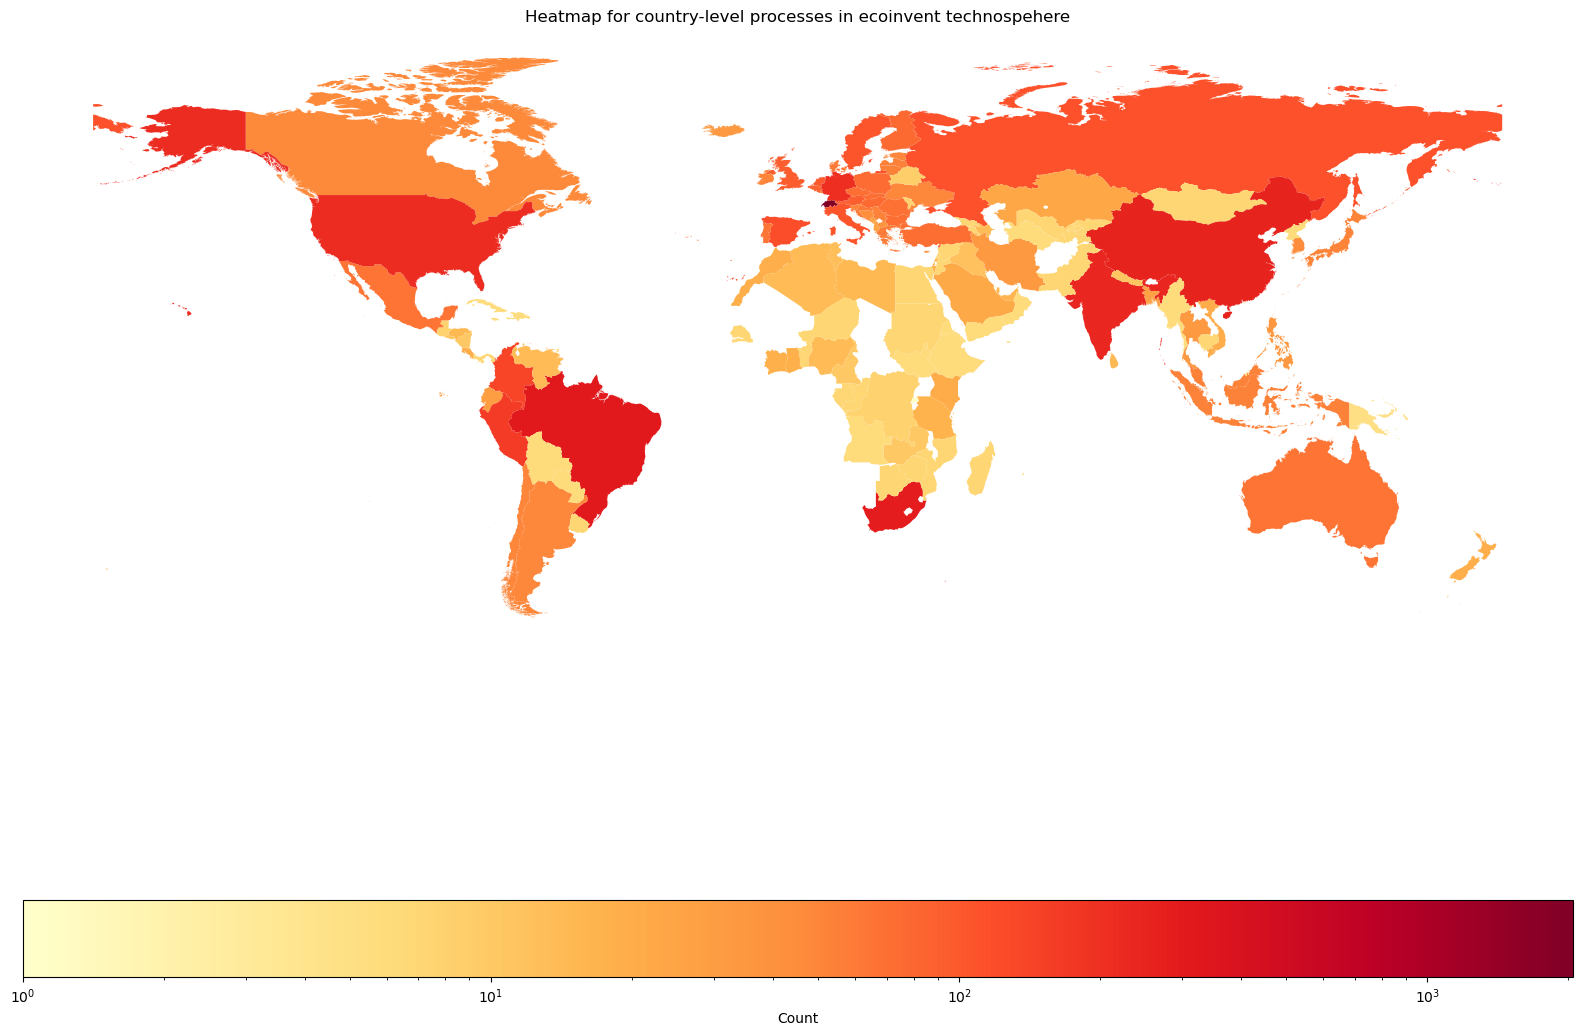

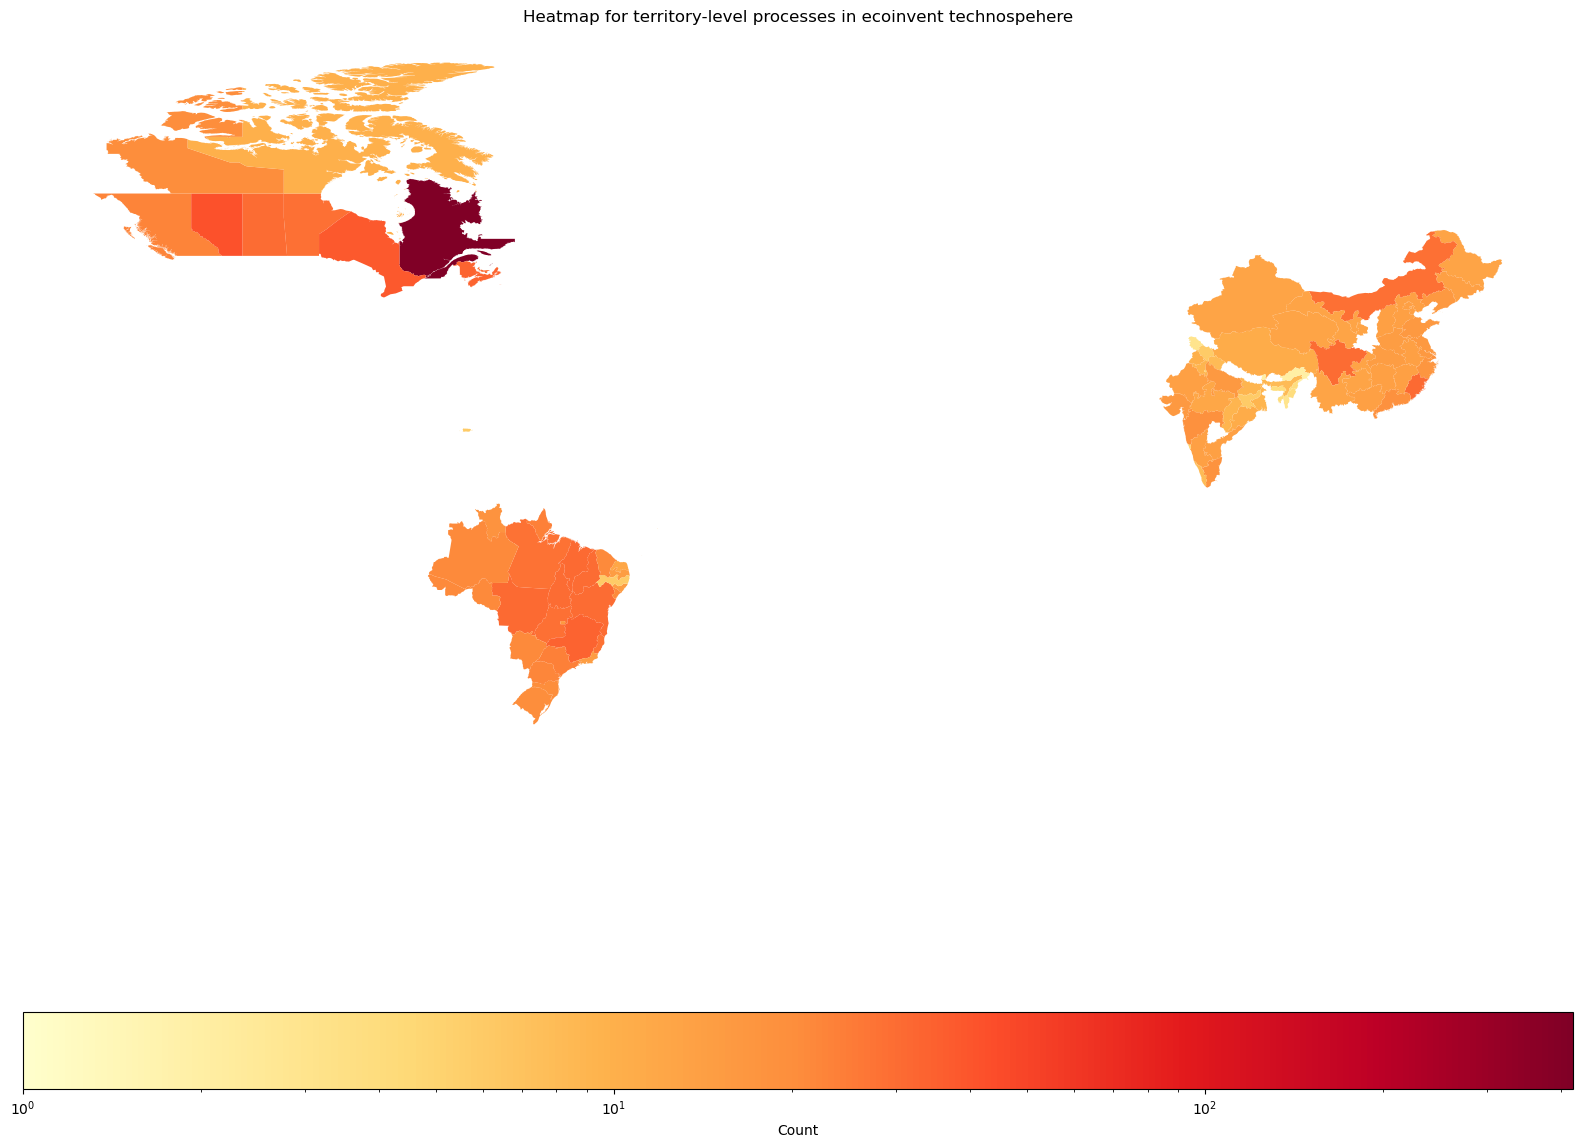

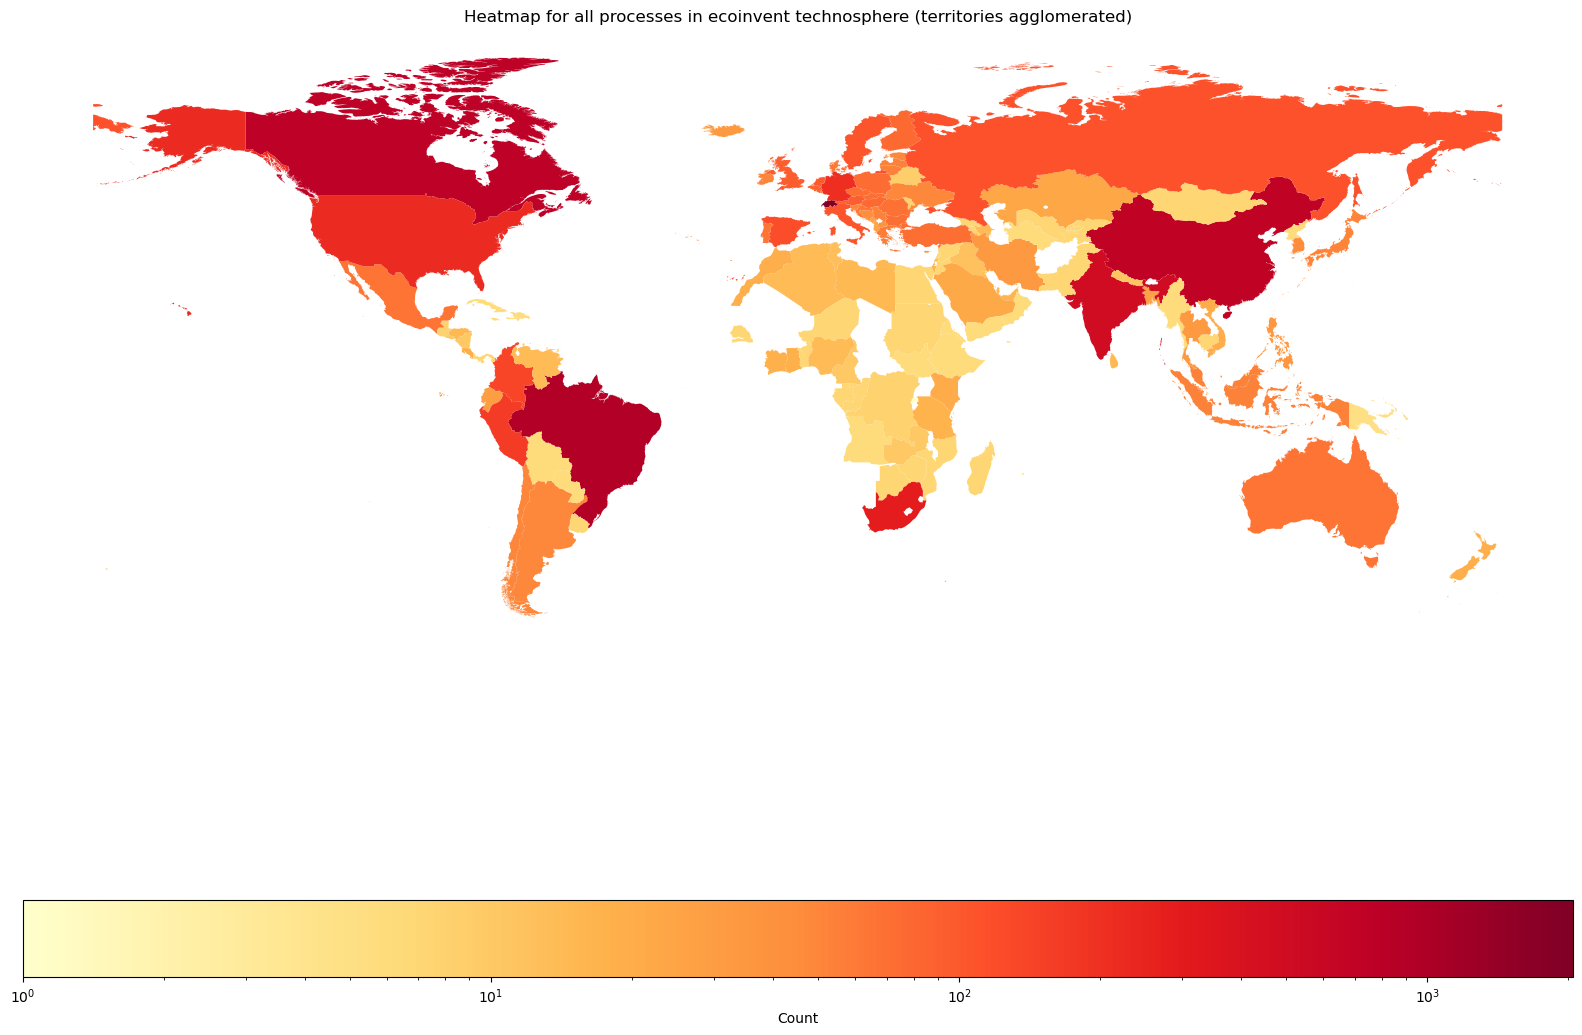

In [377]:
for name, frame in frames.items():
        fig, ax = plt.subplots(1, figsize=(20, 22))
        plot_heatmap_frame(frame, ax)
        plt.title(f"Heatmap for {name}")
        plt.savefig(f"{root}/Figures/Basic_Viz/Heatmaps/{name}")

